# The main file of the project.

The Boston Housing Dataset has been removed from the Scikit-Learn library in December 2022, after decades of its use for teaching purposes. 

Importing the dataset in the traditional way now throws the following error:

In [7]:
from sklearn import datasets

try:
    bostn = datasets.load_boston()
except Exception as e:
    print(e)



`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_d

# Obtaining the data "by hand"

The documentation of Scikit-Learn advises users to obtain the dataset in the csv format from its original source. We respect that and then convert the data to a well-formatted Pandas DataFrame. 

In the dataset, there are 14 variables:

- **CRIM**: per capita crime rate by town
- **ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**: proportion of non-retail business acres per town
- **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX**: nitric oxides concentration (parts per 10 million)
- **RM**: average number of rooms per dwelling
- **AGE**: proportion of owner-occupied units built prior to 1940
- **DIS**: weighted distances to five Boston employment centres
- **RAD**: index of accessibility to radial highways
- **TAX**: full-value property-tax rate per $10,000
- **PTRATIO**: pupil-teacher ratio by town
- **B**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- **LSTAT**: % lower status of the population
- **MEDV**: Median value of owner-occupied homes in $1000's


In [8]:
# Import the data as instructed by documentation

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# Split the data into data and target
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Convert the data to a well-formatted dataframe

column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

feature_columns = column_names[:-1]  # All columns except the target
target_column = column_names[-1]     # The target column

# Construct the features DataFrame
boston_df = pd.DataFrame(data, columns=feature_columns)

# Add the target to the DataFrame
boston_df[target_column] = target


# Exploration & Cleaning

In [9]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [10]:
boston_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

There are no missing values. Let us deploy some techniques to potentically uncover filled-in values that could affect the natural data:

## Any filled in values?

**Check if mean, median, min or max values occur suspisiously frequently in the dataset.**

Values in the dataset are rounded to 6 decimal places, match that.

In [11]:
for column in boston_df.columns:
    mean = boston_df[column].mean().round(6)
    median = boston_df[column].median().round(6)
    min_value = boston_df[column].min().round(6)
    max_value = boston_df[column].max().round(6)

    mean_frequency = (boston_df[column].round(6).value_counts().get(mean, 0) / len(boston_df)) * 100
    median_frequency = (boston_df[column].round(6).value_counts().get(median, 0) / len(boston_df)) * 100
    min_frequency = (boston_df[column].round(6).value_counts().get(min_value, 0) / len(boston_df)) * 100
    max_frequency = (boston_df[column].round(6).value_counts().get(max_value, 0) / len(boston_df)) * 100

    print(f"{column} - Mean Frequency: {mean_frequency:.2f}%, "
          f"Median Frequency: {median_frequency:.2f}%, "
          f"Min Frequency: {min_frequency:.2f}%, "
          f"Max Frequency: {max_frequency:.2f}%")


CRIM - Mean Frequency: 0.00%, Median Frequency: 0.00%, Min Frequency: 0.20%, Max Frequency: 0.20%
ZN - Mean Frequency: 0.00%, Median Frequency: 73.52%, Min Frequency: 73.52%, Max Frequency: 0.20%
INDUS - Mean Frequency: 0.00%, Median Frequency: 1.58%, Min Frequency: 0.20%, Max Frequency: 0.99%
CHAS - Mean Frequency: 0.00%, Median Frequency: 93.08%, Min Frequency: 93.08%, Max Frequency: 6.92%
NOX - Mean Frequency: 0.00%, Median Frequency: 4.55%, Min Frequency: 0.20%, Max Frequency: 3.16%
RM - Mean Frequency: 0.00%, Median Frequency: 0.00%, Min Frequency: 0.20%, Max Frequency: 0.20%
AGE - Mean Frequency: 0.00%, Median Frequency: 0.00%, Min Frequency: 0.20%, Max Frequency: 8.50%
DIS - Mean Frequency: 0.00%, Median Frequency: 0.00%, Min Frequency: 0.20%, Max Frequency: 0.20%
RAD - Mean Frequency: 0.00%, Median Frequency: 22.73%, Min Frequency: 3.95%, Max Frequency: 26.09%
TAX - Mean Frequency: 0.00%, Median Frequency: 1.98%, Min Frequency: 0.20%, Max Frequency: 0.99%
PTRATIO - Mean Frequen

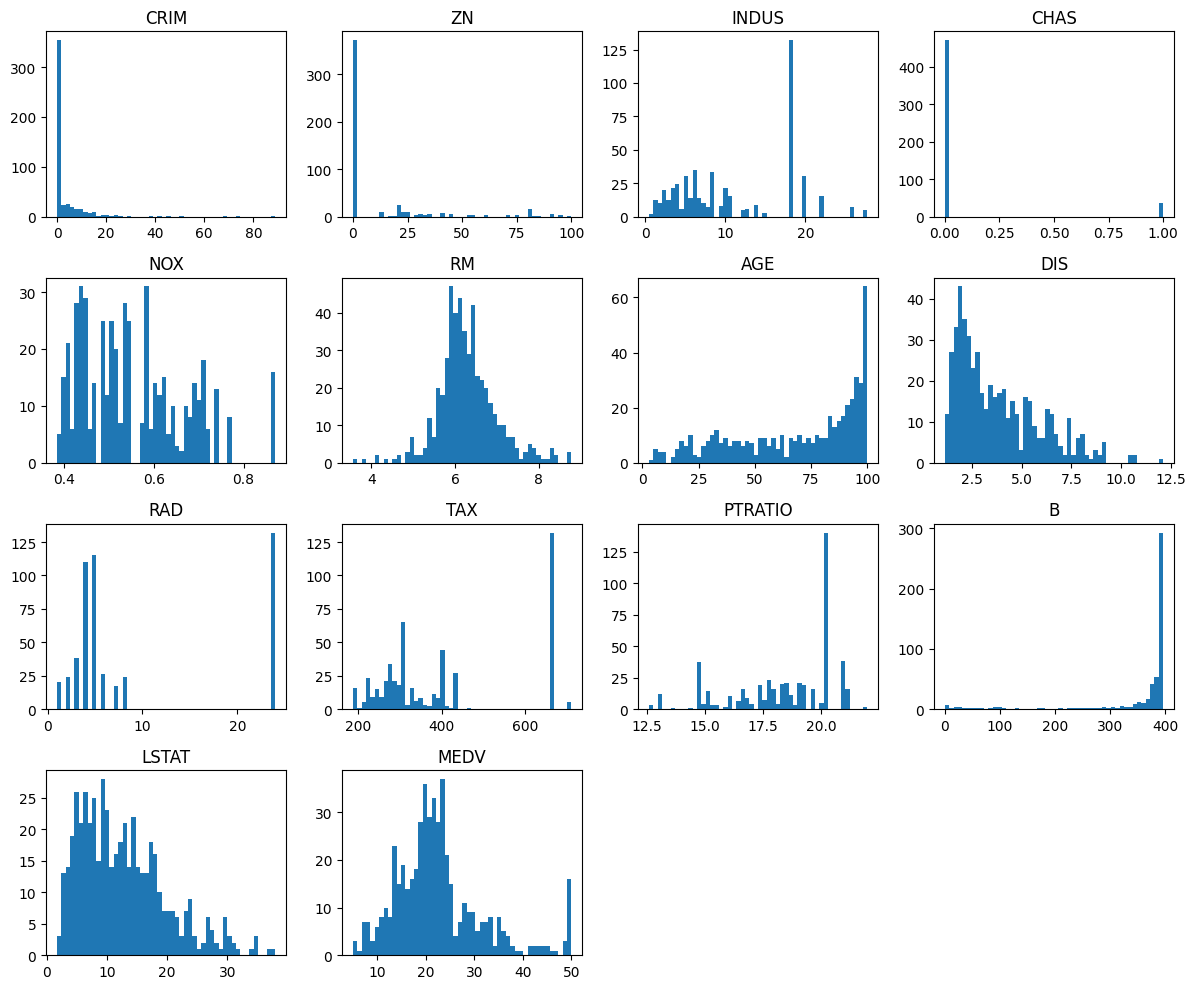

In [12]:
import matplotlib.pyplot as plt

# Plotting small histograms for each variable
boston_df.hist(figsize=(12, 10), bins=50, grid=False)
plt.tight_layout()
plt.show()


Combining the findings from checking the median, mean, min and max values together with the histograms, there should be no major concern regarding the potential influence of filled-in values. While some of the four examined measures do occur quite often in the columns, it does make sense from the nature of each specific variable.

The only questionable column is the problematic B column, which will be given more attention later.

## The LSTAT Variable

One of the problematic variables is LSTAT, a percentage of "lower status population". The original paper describes it as 

> Proportion of population that is lower status = 1/2 (proportion of adults without some high education and proportion of male workers classified as laborers)

And the authors suggest that "the effect on price is higher in the upper brackets of society", and therefore a logarithmic transform should be applied in the models.

The sole inclusion and consideration of this variable does raise concerns. For now, we will simply explore its properties and pay more attention to it later on. 

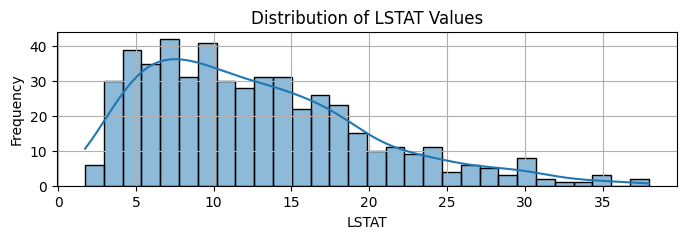

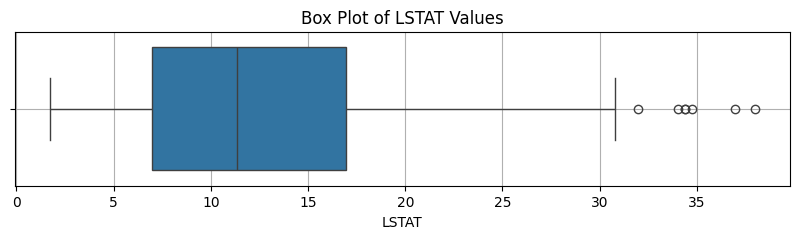

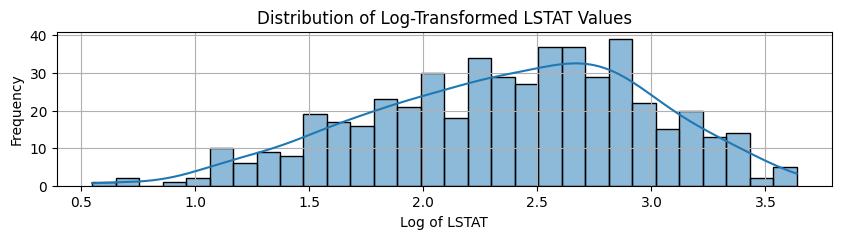

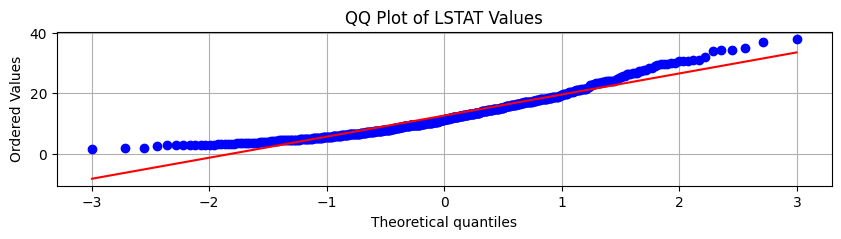

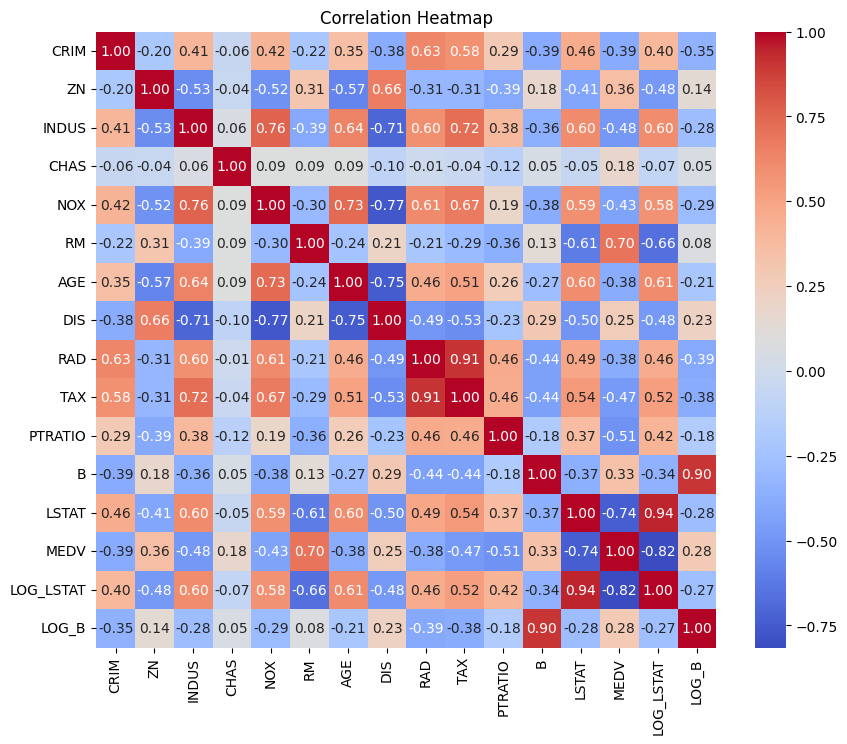

{'Basic Statistics': count    506.00
mean      12.65
std        7.14
min        1.73
25%        6.95
50%       11.36
75%       16.96
max       37.97
Name: LSTAT, dtype: float64, 'Skewness': 0.91, 'Kurtosis': 0.49, 'Correlation with RM': -0.61, 'Correlation with AGE': 0.6}


In [20]:
import app.var_examination as ve

ve.var_examination(boston_df, "LSTAT")


## TODO LSTAT findings description

## The B Variable

A key interest of this project is the B variable. We do not plan on commenting neither the reasons for its inclusion both in the original research paper and in the dataset, nor why the issues were recognized only a few years ago. We will try to examine the variable and later show its role in the dataset.

In the original research paper, the variable is described as 

> Black proportion of population. At low or moderate levels of B, an increase of B should have negative on housing values if Blacks are regarded as undesirable by Whites. However, market discrimination means that market prices are higher at very high levels of B. One expects, therefore, a parabolic relationship between proportion Black in a neighborhood and housing values.

We should note that the above **definition is wrong on many levels** and should not be considered at all in a real world scenario.

TODO

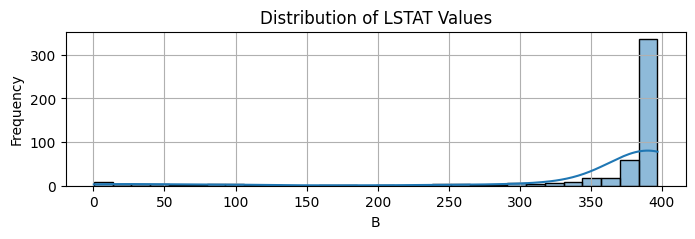

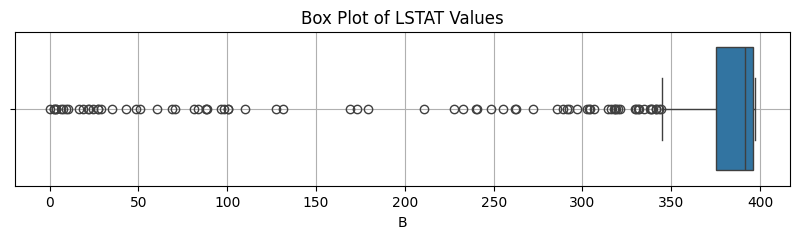

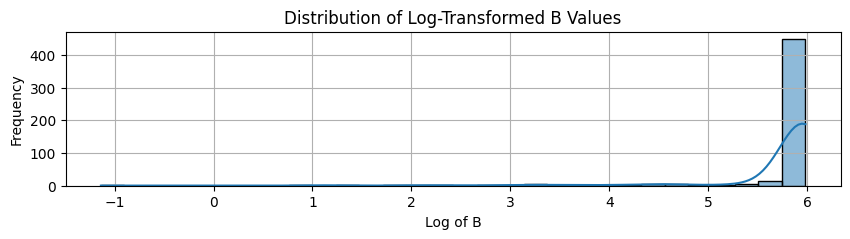

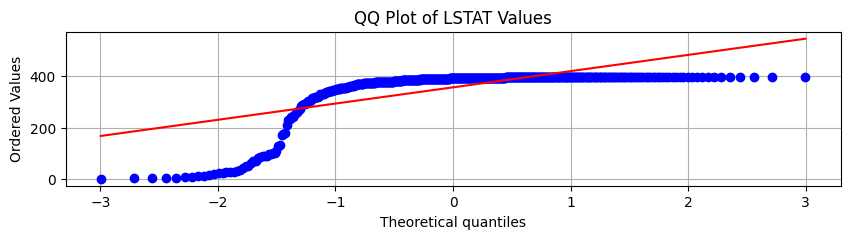

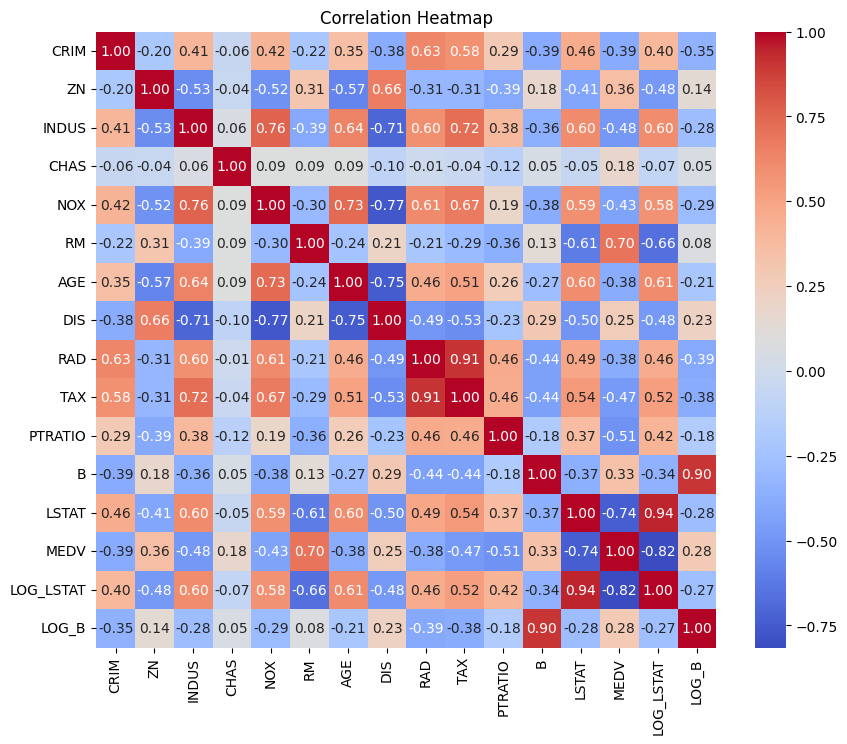

{'Basic Statistics': count    506.00
mean     356.67
std       91.29
min        0.32
25%      375.38
50%      391.44
75%      396.22
max      396.90
Name: B, dtype: float64, 'Skewness': -2.89, 'Kurtosis': 7.23, 'Correlation with RM': 0.13, 'Correlation with AGE': -0.27}


In [21]:
ve.var_examination(boston_df, "B")

TODO comments on B

TODO comments on the quadratic transformation, sus? Data distortion? We do not know what was the original number Bk

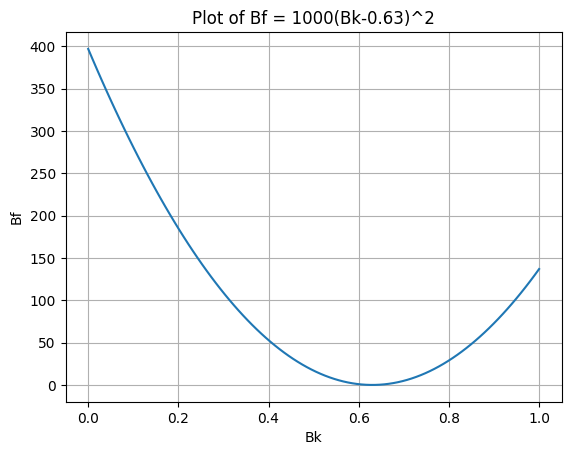

In [22]:
import numpy as np
import matplotlib.pyplot as plt

Bk = np.linspace(0, 1, 100)
Bf = 1000 * (Bk - 0.63) ** 2

plt.plot(Bk, Bf)
plt.xlabel('Bk')
plt.ylabel('Bf')
plt.title('Bf = 1000(Bk-0.63)^2')
plt.grid(True)
plt.show()
